In [5]:
import sys
sys.path.insert(0, "/home/bradhakrishnan/ECE276A_PR2/code")
data_base_path= "/home/bradhakrishnan/ECE276A_PR2/data/"

# Encoder and IMU odometry: 

Use linear velocity vt obtained from the encoders and
yaw rate ωt obtained from the IMU to predict the robot motion via the differential-drive motion
model. Assume the robot starts with identity pose. To verify that your motion model predictions
are accurate, plot the robot trajectory. You can also build a complete 2-D occupancy-grid map
by combining this trajectory with mapping before implementing scan matching.

In [6]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.linalg import expm
import jax
import matplotlib.pyplot as plt
import load_data 

jax.config.update("jax_enable_x64", True)


encoder_data= np.load(data_base_path+"Encoders20.npz")
imu_data= np.load(data_base_path+'Imu20.npz')

In [7]:
imu_angular = imu_data['angular_velocity']
imu_linear = imu_data['linear_acceleration']
imu_ts = imu_data['time_stamps']

# DATA format of encoder: [FR, FL, RR, RL]
encoder_counts= encoder_data["counts"]
encoder_ts= encoder_data["time_stamps"]

(encoder_counts, encoder_ts,
lidar_angle_min, lidar_angle_max, lidar_angle_increment,
lidar_range_min, lidar_range_max, lidar_ranges, lidar_stamps,
imu_angular, imu_linear, imu_ts,
disp_stamps, rgb_stamps) = load_data.load_dataset(20)

In [8]:
def dist_travelled(encoder_data):
    right= (encoder_data[0]+encoder_data[2])/2 * 0.0022
    left= (encoder_data[1]+encoder_data[3])/2 * 0.0022
    return left, right
ls=[]
rs=[]
for ii in range(encoder_counts.shape[-1]):
    l,r=(dist_travelled(encoder_counts[:,ii]))
    ls.append(l)
    rs.append(r)

imu_linear.shape



(3, 12187)

# Find Linear Velocity from encoders 

In [5]:
def velocity_calculator(encoder_data, encoder_ts):
    #skipping the 0th index
    del_ts= encoder_ts[1:] - encoder_ts[:-1]
    VL = 0.5*jnp.sum(encoder_data[[0, 2], 1:], axis=0)*0.0022/del_ts
    VR = 0.5*np.sum(encoder_data[[1, 3], 1:], axis=0)*0.0022/del_ts
    robo_vel = (VL+VR)/2
    return robo_vel
    
robo_vel=velocity_calculator(encoder_counts, encoder_ts)


In [6]:
def twist_creator(pose, lin_vel, ang_vel):
    # Create a 4x4 matrix of zeros
    twist = np.zeros((4, 4))
    
    # Set the last column to lin_vel (with a zero appended at the end)
    vel_x= lin_vel*pose[0,0] # v cos(theta)
    vel_y= lin_vel*pose[1,0] # v sin(theta)
    vel_z=0
    twist[0:3, 3] = jnp.array([vel_x, vel_y, vel_z])
    
    # Set the element at first row, second column to -ang_vel[2]
    twist[0, 1] = -ang_vel[2]
    
    # Set the element at second row, first column to the third element of lin_vel
    twist[1, 0] = ang_vel[2]
    
    return twist

In [6]:
def time_sync(time_stamp_1, time_stamp_2):
    ts_synced = {}
    for ts in time_stamp_1:
        ts_synced[ts] = np.argmin(np.abs(ts-time_stamp_2))
    return ts_synced

imu_sync_map= time_sync(encoder_ts[1:], imu_ts[:-1])

# Motion Model

In [57]:
T_0= jnp.eye(4)
poses= [T_0]
del_ts= encoder_ts[1:] - encoder_ts[:-1]
for ii in range(0,encoder_counts.shape[-1]-1):
    ang_vel= imu_angular[:,imu_sync_map[encoder_ts[ii+1]]]
    lin_vel= robo_vel[ii]
    del_T= del_ts[ii]
    twist= twist_creator(poses[ii],lin_vel,ang_vel)
    pred_T= poses[ii]@expm(del_T* twist)
    poses.append(pred_T)
    
poses= jnp.array(poses)

Array([[ 9.99999993e-01, -1.16761034e-04,  0.00000000e+00,
         0.00000000e+00],
       [ 1.16761034e-04,  9.99999993e-01,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]], dtype=float64)

In [59]:
xy_positions = jnp.array([ [pose[0, 3], pose[1, 3]] for pose in poses ])


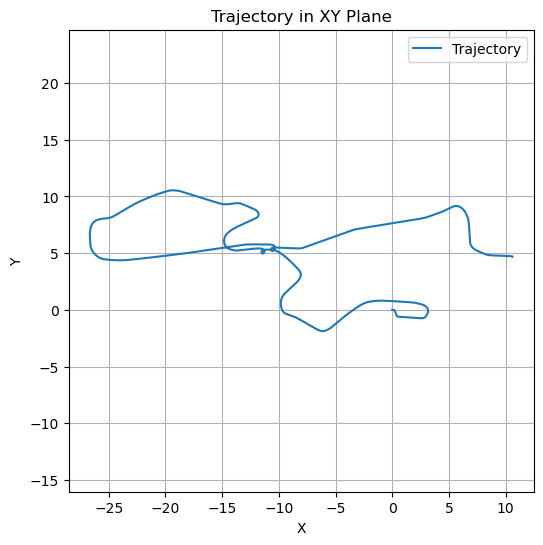

In [60]:
import matplotlib.pyplot as plt
# Plot the trajectory in the xy plane.
xy_positions = jnp.array([ [pose[0, 3], pose[1, 3]] for pose in poses ])

plt.figure(figsize=(6, 6))
plt.plot(xy_positions[:, 0], xy_positions[:, 1], label='Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectory in XY Plane')
plt.grid(True)
plt.axis('equal')  # Ensure equal scaling on both axes.
plt.legend()
plt.show()

# Using SE(2)

In [7]:
intial_traj=jnp.zeros(3)
traj=[intial_traj]
del_ts= encoder_ts[1:] - encoder_ts[:-1]

for ii in range(0,encoder_counts.shape[-1]-1):
    del_t= del_ts[ii]
    curr_traj= traj[ii]
    lin_vel= robo_vel[ii]
    ang_vel= imu_angular[:,imu_sync_map[encoder_ts[ii+1]]][-1]
    traj_pred=curr_traj+del_t*np.array([lin_vel*jnp.cos(curr_traj[-1]),lin_vel*jnp.sin(curr_traj[-1]),ang_vel])
    traj.append(traj_pred)


traj=np.array(traj).T

Text(0.5, 1.0, 'Trajectory')

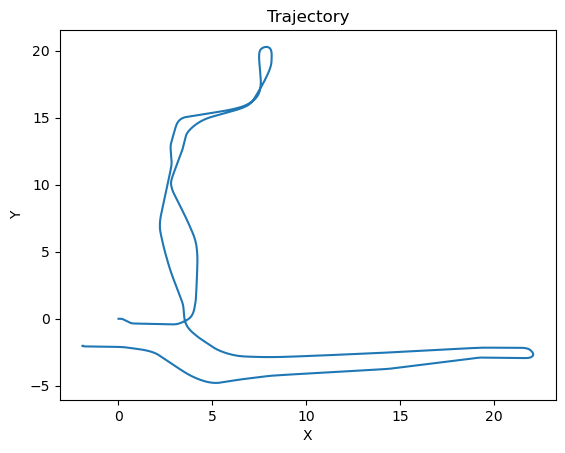

In [8]:
plt.plot(traj[0, :], traj[1, :])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectory')


In [9]:
lidar_angle_max 

array(2.35619449)

In [ ]:
lidar_angle_min, lidar_angle_max, lidar_angle_increment,
lidar_range_min, lidar_range_max, lidar_ranges, lidar_stamps

In [23]:
lidar_angle_increment

array([[0.00436332]])

In [12]:
lidar_range_min

array(0.1)

In [13]:
lidar_range_max

array(30)

In [15]:
lidar_ranges.shape

(1081, 4962)

In [17]:
lidar_stamps.shape

(4962,)

In [22]:
lidar_ranges[:,2]

array([3.39400005, 3.39899993, 3.39899993, ..., 4.91900015, 4.91900015,
       4.91900015])

In [4]:
lidarAzimuths = np.arange(lidar_angle_min, lidar_angle_max + lidar_angle_increment/2 , lidar_angle_increment)

NameError: name 'lidar_angle_min' is not defined

In [26]:
lidarAzimuths

array([-2.35619449, -2.35183117, -2.34746784, ...,  2.34746784,
        2.35183117,  2.35619449])

In [28]:
135+135


270